# Title

Explanation

## Import Packages

In [1]:
import pandas as pd
from pandas import util
import numpy as np
import re
import os

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import glob

## Load Data

In [3]:
# Load the total reviews together
data = pd.read_csv("./Data/total_google_reviews.csv")

# Preview
data.head()

,Venue Index,Name,Review Rate,Review Time,Review Text
0,0,Ellis,5 stars,3 years ago,"It was a bit quite when we went in, but don’t ..."
1,1,Ellis,5 stars,2 years ago,Nice cozy place which serves very tasty burger...
2,2,Ellis,5 stars,3 years ago,Really nice place. One of my favourite burger ...
3,3,Ellis,2 stars,3 years ago,The Service was quite good but the burgers we ...
4,4,Ellis,5 stars,2 years ago,I had a very nice experience! The staff were r...


In [4]:
# Preview of one review
data.iloc[0][4]

'It was a bit quite when we went in, but don’t let that fool you if it’s ever the case! After a little while the place was cozily busy. Rightfully so! The burgers (and nachos) were lovely, as was the staff. I would definitely recommend this place if you’re around and in the need of a good burger.'

In [5]:
# Shape of the df
data.shape #(577530, 5)

(577530, 5)

In [6]:
# Change the column names
data = data.rename(columns={"Review Rate": "Rating", "Review Time": "Date", "Review Text": "Text"})
data.head()

,Venue Index,Name,Rating,Date,Text
0,0,Ellis,5 stars,3 years ago,"It was a bit quite when we went in, but don’t ..."
1,1,Ellis,5 stars,2 years ago,Nice cozy place which serves very tasty burger...
2,2,Ellis,5 stars,3 years ago,Really nice place. One of my favourite burger ...
3,3,Ellis,2 stars,3 years ago,The Service was quite good but the burgers we ...
4,4,Ellis,5 stars,2 years ago,I had a very nice experience! The staff were r...


## Cleaning Data

In [7]:
# Removing empty reviews
def remove_nan(data, column_name):
    '''Returns data where values in column_name are not empty (NaN)'''
    
    data = data[data[column_name].notna()]
    
    return data

# Removing original languages and Cleaning strings
def clean_string(text):
    '''Returns the (Translated by Google) English text, removes the (Original) text from the text.
        sep specifies what separator to separate the text by.'''
    
    sep = "(Original)"
    if sep in text:
        translation, separator, original = text.partition(sep)
        text = translation
    
    '''Lowercases reviews, removes \n and (translated by google).'''
    
    text = str(text)                                         # Change type to string
    text = text.lower()                                      # Set all text to lower string
    text = text.replace("\n", '')
    text = text.replace("(translated by google)", '')        
    
    text = re.sub("n’t", ' not', text)                       # Change n't to not
    text = re.sub(" +", " ", text)                           # Remove multiple spaces
    text = re.sub(r"http.*?(?=\s)", "", text)                # Remove URL's
    text = re.sub("'"," ", text)                             # Remove apostrophes
        
    return text

In [8]:
%%time
data = remove_nan(data, "Text")

CPU times: user 58.7 ms, sys: 10 ms, total: 68.7 ms
Wall time: 74.7 ms


In [9]:
%%time
data['Cleaned Text'] = data["Text"].apply(clean_string)

CPU times: user 4.73 s, sys: 57.2 ms, total: 4.79 s
Wall time: 4.81 s


In [10]:
# Preview cleaned text
data.head()

,Venue Index,Name,Rating,Date,Text,Cleaned Text
0,0,Ellis,5 stars,3 years ago,"It was a bit quite when we went in, but don’t ...","it was a bit quite when we went in, but do not..."
1,1,Ellis,5 stars,2 years ago,Nice cozy place which serves very tasty burger...,nice cozy place which serves very tasty burger...
2,2,Ellis,5 stars,3 years ago,Really nice place. One of my favourite burger ...,really nice place. one of my favourite burger ...
3,3,Ellis,2 stars,3 years ago,The Service was quite good but the burgers we ...,the service was quite good but the burgers we ...
4,4,Ellis,5 stars,2 years ago,I had a very nice experience! The staff were r...,i had a very nice experience! the staff were r...


## Pre-Processing

In [11]:
# Change rating to positive, negative or neutral label
def rating_to_sent(text):
    '''Change Rating to integer score from 1 to 5.'''
    
    texts = str(text)
    text = text.replace("stars", '')
    text = text.replace("star", '')
    text = text.replace(" ", '')
    score = int(text)
    
    '''Change score to positive, negative or neutral'''
    
    if score > 3:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'  
    
# Change relative Date to absolute Date
def abs_date(text):
    '''Change relative date to absolute date'''
    
    text = str(text)
    text = text.replace(" ago", "")
    text = text.replace("years", "year")
    text = text.replace("months", "month")
    text = text.replace("weeks", "week")
    text = text.replace("days", "day")
    text = text.replace("hours", "hour")
    text = text.replace("minutes", "minute")
    
    num, metric = text.split(' ')
    
    if num == 'a' or num =='an':
        num = 1
    
    num = int(num)
    
    if "year" in metric:
        text = 2022 - num
    elif "month" in metric and num > 3:
        text = 2021
    elif "month" in metric and num < 4:
        text = 2022
    elif "day" in metric or "week" in metric or "hour" in metric or "minute" in metric:
        text = 2022
    
    date = int(text)
    
    return date

In [12]:
%%time
data['Rating Sent'] = data["Rating"].apply(rating_to_sent)

CPU times: user 337 ms, sys: 11.7 ms, total: 349 ms
Wall time: 362 ms


In [13]:
%%time
data['Date'] = data["Date"].apply(abs_date)

CPU times: user 718 ms, sys: 30.9 ms, total: 749 ms
Wall time: 758 ms


In [14]:
data = data.reindex(columns=['Venue Index', 'Name', 'Date', 'Rating', 'Rating Sent', 'Text', 'Cleaned Text'])
data.head()

,Venue Index,Name,Date,Rating,Rating Sent,Text,Cleaned Text
0,0,Ellis,2019,5 stars,positive,"It was a bit quite when we went in, but don’t ...","it was a bit quite when we went in, but do not..."
1,1,Ellis,2020,5 stars,positive,Nice cozy place which serves very tasty burger...,nice cozy place which serves very tasty burger...
2,2,Ellis,2019,5 stars,positive,Really nice place. One of my favourite burger ...,really nice place. one of my favourite burger ...
3,3,Ellis,2019,2 stars,negative,The Service was quite good but the burgers we ...,the service was quite good but the burgers we ...
4,4,Ellis,2020,5 stars,positive,I had a very nice experience! The staff were r...,i had a very nice experience! the staff were r...


In [15]:
# Find the shape of the data
data.shape #(403843, 7)

(403843, 7)

## Tokenization and Lemmatization

In [16]:
# Sentence tokenization
def sent_tok(text):
    '''Sentence tokenize.
    Returns list of sentences in review.'''
    
    text = sent_tokenize(text)
    
    return text

# Word tokenization and Removing stopwords
def word_tok(text):
    '''Word tokenize.
    Returns list of words in review.'''
    
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = word_tokenize(text)
    
    filtered_text = [word for word in text if not word in stop_words]
    
    return filtered_text

def lemmatize_string(text):
    '''Lemmatize words in a list.'''
    
    lemma_text = [lemmatizer.lemmatize(word) for word in text]
       
    return lemma_text

In [17]:
# Stopwords
stop_words = stopwords.words('english')

# Lemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
%%time
data["Sentences"] = data["Cleaned Text"].apply(sent_tok)

CPU times: user 25.6 s, sys: 207 ms, total: 25.8 s
Wall time: 26.2 s


In [19]:
%%time
data["Words"] = data["Cleaned Text"].apply(word_tok)

CPU times: user 1min 11s, sys: 445 ms, total: 1min 12s
Wall time: 1min 12s


In [20]:
%%time
data["Words"] = data["Words"].apply(lemmatize_string)
data.head()

CPU times: user 17.7 s, sys: 237 ms, total: 18 s
Wall time: 18 s


,Venue Index,Name,Date,Rating,Rating Sent,Text,Cleaned Text,Sentences,Words
0,0,Ellis,2019,5 stars,positive,"It was a bit quite when we went in, but don’t ...","it was a bit quite when we went in, but do not...","[it was a bit quite when we went in, but do no...","[bit, quite, went, let, fool, ever, case, litt..."
1,1,Ellis,2020,5 stars,positive,Nice cozy place which serves very tasty burger...,nice cozy place which serves very tasty burger...,[nice cozy place which serves very tasty burge...,"[nice, cozy, place, serf, tasty, burger, staff..."
2,2,Ellis,2019,5 stars,positive,Really nice place. One of my favourite burger ...,really nice place. one of my favourite burger ...,"[really nice place., one of my favourite burge...","[really, nice, place, one, favourite, burger, ..."
3,3,Ellis,2019,2 stars,negative,The Service was quite good but the burgers we ...,the service was quite good but the burgers we ...,[the service was quite good but the burgers we...,"[service, quite, good, burger, ordered, small,..."
4,4,Ellis,2020,5 stars,positive,I had a very nice experience! The staff were r...,i had a very nice experience! the staff were r...,"[i had a very nice experience!, the staff were...","[nice, experience, staff, really, nice, kind, ..."


In [21]:
# Save the data
data.to_csv("./Data/preprocessed_data.csv")

## EDA

In [22]:
# Find the number of reviews that contain a specific word
print("Nr. reviews containing 'wheelchair':", data[data["Text"].str.contains("wheelchair")].shape[0])
print("Nr. reviews containing 'ramp':", data[data["Text"].str.contains("ramp")].shape[0])
print("Nr. reviews containing 'disabled':", data[data["Text"].str.contains("disabled")].shape[0])
print("Nr. reviews containing 'stairs':", data[data["Text"].str.contains("stairs")].shape[0])
print("Nr. reviews containing 'steps':", data[data["Text"].str.contains("steps")].shape[0])
print("Nr. reviews containing 'step':", data[data["Text"].str.contains("steps")].shape[0])
print("Nr. reviews containing 'disability':", data[data["Text"].str.contains("disability")].shape[0])
print("Nr. reviews containing 'narrow entrance':", data[data["Text"].str.contains("narrow entrance")].shape[0])
print("Nr. reviews containing 'wide entrance':", data[data["Text"].str.contains("wide entrance")].shape[0])
print("Nr. reviews containing 'small entrance':", data[data["Text"].str.contains("small entrance")].shape[0])
print("Nr. reviews containing 'narrow door':", data[data["Text"].str.contains("narrow door")].shape[0])
print("Nr. reviews containing 'wide door':", data[data["Text"].str.contains("wide door")].shape[0])
print("Nr. reviews containing 'accessible toilet':", data[data["Text"].str.contains("accessible toilet")].shape[0])
print("Nr. reviews containing 'accessible bathroom':", data[data["Text"].str.contains("accessible bathroom")].shape[0])
print("Nr. reviews containing 'elevator':", data[data["Text"].str.contains("elevator")].shape[0])
print("Nr. reviews containing 'handicap':", data[data["Text"].str.contains("handicap")].shape[0])
print("Nr. reviews containing 'steep':", data[data["Text"].str.contains("steep")].shape[0])
print("Nr. reviews containing 'steep stairs':", data[data["Text"].str.contains("steep stairs")].shape[0])
print("Nr. reviews containing 'narrow stairs':", data[data["Text"].str.contains("narrow stairs")].shape[0])
print("Nr. reviews containing 'small stairs':", data[data["Text"].str.contains("small stairs")].shape[0])
print("Nr. reviews containing 'dangerous stairs':", data[data["Text"].str.contains("dangerous stairs")].shape[0])
print("Nr. reviews containing 'slippery':", data[data["Text"].str.contains("slippery")].shape[0])

Nr. reviews containing 'wheelchair': 108
Nr. reviews containing 'ramp': 358
Nr. reviews containing 'disabled': 54
Nr. reviews containing 'stairs': 1290
Nr. reviews containing 'steps': 111
Nr. reviews containing 'step': 111
Nr. reviews containing 'disability': 2
Nr. reviews containing 'narrow entrance': 2
Nr. reviews containing 'wide entrance': 1
Nr. reviews containing 'small entrance': 0
Nr. reviews containing 'narrow door': 0
Nr. reviews containing 'wide door': 0
Nr. reviews containing 'accessible toilet': 3
Nr. reviews containing 'accessible bathroom': 2
Nr. reviews containing 'elevator': 34
Nr. reviews containing 'handicap': 19
Nr. reviews containing 'steep': 228
Nr. reviews containing 'steep stairs': 39
Nr. reviews containing 'narrow stairs': 10
Nr. reviews containing 'small stairs': 0
Nr. reviews containing 'dangerous stairs': 2
Nr. reviews containing 'slippery': 13


## Training and Test data

In [23]:
data.shape

(403843, 9)

In [24]:
403843*0.8

323074.4

In [25]:
shuffled_data = data.sample(frac=1)

In [26]:
shuffled_data.to_csv("./Data/shuffled_data.csv")

In [27]:
shuffled_data["Accessibility"] = 0
#shuffled_data["Aspect"] = 0

In [28]:
train_data = shuffled_data[:323074]
test_data = shuffled_data[323075:]

In [29]:
train_data.head()

,Venue Index,Name,Date,Rating,Rating Sent,Text,Cleaned Text,Sentences,Words,Accessibility
446906,641,Bakers and Roasters,2021,5 stars,positive,(Translated by Google) Extremely delicious foo...,extremely delicious food with a large selecti...,[ extremely delicious food with a large select...,"[extremely, delicious, food, large, selection,...",0
4627,47,il Palio,2020,5 stars,positive,"Excellent menu, wine selection and service. We...","excellent menu, wine selection and service. we...","[excellent menu, wine selection and service., ...","[excellent, menu, wine, selection, service, th...",0
231842,437,Caf√© Thijssen,2018,5 stars,positive,"(Translated by Google) Good atmosphere, good b...","good atmosphere, good beer!","[ good atmosphere, good beer!]","[good, atmosphere, good, beer]",0
408571,206,Lot Sixty One Coffee Roasters,2018,5 stars,positive,Very nice looking place with a really chill at...,very nice looking place with a really chill at...,[very nice looking place with a really chill a...,"[nice, looking, place, really, chill, atmosphe...",0
430682,47,Tijger & de Vis,2019,5 stars,positive,Kibbeling is Very Delicious (Kibbeling is a Du...,kibbeling is very delicious (kibbeling is a du...,[kibbeling is very delicious (kibbeling is a d...,"[kibbeling, delicious, kibbeling, dutch, snack...",0


In [30]:
# Save data
train_data.to_csv("./Data/train_data.csv")
test_data.to_csv("./Data/test_data.csv")

## Text Classification

### Rule-based System

In [31]:
# Groups: discusses accessibility, does not disbuss accessibility

# Accessibility vocabulary
general_words =["wheelchair", "disability", "disabled", "handicap", "mobility"]
venue_words = ["entrance", " stairs", "door", " staircase", "toilet", "bathroom",
               "restroom", "elevator", " ramp ", "steps"]
description_words = ["cramped", "narrow", "small", "steep", "wide", "spacious",
                     " downstairs", " upstairs", " stairs", " staircase", "ramp", "steps"]

In [47]:
def accessibility_classification(text):
    '''Classifies sentences based on accessibility vocabilary.'''
    
    acc_list = []
    
    for s in text:
        if any(word in s for word in general_words):
            classify = 1
        elif any(word in s for word in venue_words) and any(word in s for word in description_words):
            classify = 1
        else:
            classify = 0
        acc_list.append(classify)
    
    text = acc_list

    return text

def 

In [49]:
%%time
train_data["Accessibility"] = train_data["Sentences"].apply(accessibility_classification)
train_data.head()

CPU times: user 2.16 s, sys: 340 ms, total: 2.5 s
Wall time: 2.58 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Venue Index,Name,Date,Rating,Rating Sent,Text,Cleaned Text,Sentences,Words,Accessibility
446906,641,Bakers and Roasters,2021,5 stars,positive,(Translated by Google) Extremely delicious foo...,extremely delicious food with a large selecti...,[ extremely delicious food with a large select...,"[extremely, delicious, food, large, selection,...","[0, 0, 0]"
4627,47,il Palio,2020,5 stars,positive,"Excellent menu, wine selection and service. We...","excellent menu, wine selection and service. we...","[excellent menu, wine selection and service., ...","[excellent, menu, wine, selection, service, th...","[0, 0, 0, 0, 0]"
231842,437,Caf√© Thijssen,2018,5 stars,positive,"(Translated by Google) Good atmosphere, good b...","good atmosphere, good beer!","[ good atmosphere, good beer!]","[good, atmosphere, good, beer]",[0]
408571,206,Lot Sixty One Coffee Roasters,2018,5 stars,positive,Very nice looking place with a really chill at...,very nice looking place with a really chill at...,[very nice looking place with a really chill a...,"[nice, looking, place, really, chill, atmosphe...","[0, 0, 0]"
430682,47,Tijger & de Vis,2019,5 stars,positive,Kibbeling is Very Delicious (Kibbeling is a Du...,kibbeling is very delicious (kibbeling is a du...,[kibbeling is very delicious (kibbeling is a d...,"[kibbeling, delicious, kibbeling, dutch, snack...","[0, 0]"


In [53]:
# Save data
train_data.to_csv("./Data/labelled_train_data.csv")

In [83]:
# Create a new DataFrame that only contains accessibility sentences.
filtered_train_data = train_data.copy()

In [85]:
def filter_data(text):
    '''Returns 1 if accessibility list contains a 1.'''
    
    if 1 in text:
        return 1

In [86]:
%%time
filtered_train_data["Bool Accessibility"] = filtered_train_data["Accessibility"].apply(filter_data)

CPU times: user 110 ms, sys: 27.8 ms, total: 138 ms
Wall time: 149 ms


In [89]:
# Filter data based on whether it contains a sentence that discusses accessibility
filtered_train_data = filtered_train_data[filtered_train_data["Bool Accessibility"]==1]

In [96]:
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

In [124]:
def filter_sent():
    
    sentence_lst = []
    name_lst = []
    
    for sentences in filtered_train_data["Sentences"]:
        row = 
        
        for acc in filtered_train_data["Accessibility"]:
            ind_lst = get_index_positions(acc, 1)
        
        for ind in ind_lst:
            sentence_lst.append(sentences[ind])
            name_lst.append(filtered_train_data["Name"])
                  
    return sentence_lst

In [125]:
filtered_sentence_lst = filter_sent()

In [141]:
accessibility_df = pd.DataFrame(columns=["Name", "Sentence"])
accessibility_df["Sentence"] = filtered_sentence_lst
accessibility_df.head()

,Name,Sentence
0,NaN,"great place and the breakfast is delicious, h..."
1,NaN,the stairs are a little steep!but that s fine!
2,NaN,"of the beautiful cafes in amsterdam, the plac..."
3,NaN,"delicious food, restaurant adapted to mentall..."
4,NaN,"location 2 steps from the center, but not cro..."


In [142]:
accessibility_df.shape

(752, 2)

## LDA

In [143]:
# Load the regular expression library
import re
# Remove punctuation
accessibility_df['Clean Sentence'] = \
accessibility_df['Clean Sentence'] = accessibility_df['Sentence'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
accessibility_df['Clean Sentence'] = \
accessibility_df['Clean Sentence'].map(lambda x: x.lower())
accessibility_df.head()

,Name,Sentence,Clean Sentence
0,NaN,"great place and the breakfast is delicious, h...",great place and the breakfast is delicious ho...
1,NaN,the stairs are a little steep!but that s fine!,the stairs are a little steepbut that s fine
2,NaN,"of the beautiful cafes in amsterdam, the plac...",of the beautiful cafes in amsterdam the place...
3,NaN,"delicious food, restaurant adapted to mentall...",delicious food restaurant adapted to mentally...
4,NaN,"location 2 steps from the center, but not cro...",location 2 steps from the center but not crow...


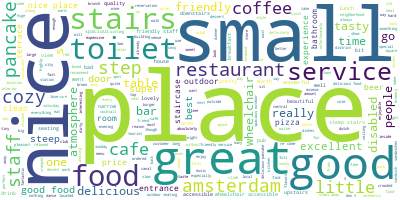

In [134]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(accessibility_df['Clean Sentence'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [150]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [151]:
import string
import gensim
from gensim.utils import simple_preprocess

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer

accessibility_df = accessibility_df.rename(columns={"Clean Sentence": "clean_sentence"})

accessibility_df_lst = accessibility_df.clean_sentence.values.tolist()
accessibility_df_words = list(sent_to_words(accessibility_df_lst))
# remove stop words
accessibility_df_words = remove_stopwords(accessibility_df_words)
print(accessibility_df_words[:1][0][:30])

['great', 'place', 'breakfast', 'delicious', 'however', 'toilets', 'bit', 'grim']


In [153]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(accessibility_df_words)
# Create Corpus
texts = accessibility_df_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [154]:
from pprint import pprint
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"small" + 0.022*"cafe" + 0.019*"great" + 0.019*"toilet" + '
  '0.019*"nice" + 0.018*"place" + 0.017*"steps" + 0.013*"cozy" + '
  '0.010*"upstairs" + 0.010*"time"'),
 (1,
  '0.029*"food" + 0.019*"service" + 0.018*"toilet" + 0.016*"great" + '
  '0.015*"disabled" + 0.013*"tasty" + 0.011*"went" + 0.010*"wheelchair" + '
  '0.010*"friendly" + 0.008*"steps"'),
 (2,
  '0.033*"place" + 0.033*"good" + 0.023*"stairs" + 0.023*"food" + '
  '0.015*"outdoor" + 0.013*"seating" + 0.013*"nice" + 0.010*"steep" + '
  '0.010*"best" + 0.010*"service"'),
 (3,
  '0.027*"delicious" + 0.020*"nice" + 0.018*"pancakes" + 0.016*"great" + '
  '0.016*"food" + 0.016*"good" + 0.015*"small" + 0.012*"outdoor" + '
  '0.012*"cozy" + 0.012*"experience"'),
 (4,
  '0.037*"small" + 0.025*"good" + 0.020*"nice" + 0.018*"stairs" + '
  '0.013*"outdoor" + 0.013*"tables" + 0.011*"toilet" + 0.010*"staff" + '
  '0.010*"wheelchair" + 0.010*"steep"'),
 (5,
  '0.019*"place" + 0.016*"tasty" + 0.012*"staff" + 0.012*"great" + 

## Sentiment Analysis

In [2]:
train_data.head()

NameError: name 'train_data' is not defined